In [10]:
import functools
from time import time

import numpy as np
import pandas as pd
from sid import get_msm_func
from sid import get_simulate_func
from sid.msm import get_diag_weighting_matrix

from src.calculate_moments import smoothed_outcome_per_hundred_thousand_rki
from src.calculate_moments import smoothed_outcome_per_hundred_thousand_sim
from src.config import BLD
from src.config import SRC
from src.contact_models.get_contact_models import get_all_contact_models
from src.create_initial_states.create_initial_conditions import \
    create_initial_conditions
from src.plotting.plot_msm_performance import plot_msm_performance
from src.plotting.policy_gantt_chart import make_gantt_chart_of_policy_dict

%load_ext snakeviz
import hashlib
import os


def hash_array(arr):
    """Create a hashsum for fast comparison of numpy arrays."""
    # make the array exactly representable as float
    arr = 1 + arr - 1
    return hashlib.sha1(arr.tobytes()).hexdigest()

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [2]:
ESTIMATION_START = pd.Timestamp("2020-08-15")
ESTIMATION_END = pd.Timestamp("2020-12-05")
ESTIMATION_END = pd.Timestamp("2020-08-20")

INIT_START = ESTIMATION_START - pd.Timedelta(31, unit="D")
INIT_END = ESTIMATION_START - pd.Timedelta(1, unit="D")

In [3]:
initial_conditions = create_initial_conditions(
    start=INIT_START, end=INIT_END, undetected_multiplier=4.0, seed=3484
)

In [4]:
contact_models = get_all_contact_models()

In [5]:
params = pd.read_pickle(BLD / "start_params.pkl")
initial_states = pd.read_parquet(BLD / "data" / "initial_states.parquet")

params.loc["infection_prob"]

hh_prob = ("infection_prob", "household", "household")
educ_models = [cm for cm in contact_models if "educ" in cm]
educ_probs = params.query(
    f"category == 'infection_prob' & subcategory in {educ_models}"
).index
work_models = [cm for cm in contact_models if "work" in cm]
work_probs = params.query(
    f"category == 'infection_prob' & subcategory in {work_models}"
).index
other_models = [cm for cm in contact_models if "other" in cm]
other_probs = params.query(
    f"category == 'infection_prob' & subcategory in {other_models}"
).index
school_models = [
    cm
    for cm in contact_models
    if "educ" in cm and "school" in cm and not "preschool" in cm
]
school_probs = params.query(
    f"category == 'infection_prob' & subcategory in {school_models}"
).index

params.loc[educ_probs, "value"] = 0.02
params.loc[school_probs, "value"] = 0.004
params.loc[other_probs, "value"] = 0.1
params.loc[work_probs, "value"] = 0.1
params.loc[hh_prob] = 0.2


params.loc["infection_prob"]
school_probs

/home/janos/anaconda3/envs/sid-germany/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2877: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


MultiIndex([('infection_prob', 'educ_school_0', 'educ_school_0'),
            ('infection_prob', 'educ_school_1', 'educ_school_1'),
            ('infection_prob', 'educ_school_2', 'educ_school_2')],
           names=['category', 'subcategory', 'name'])

In [6]:
from src.policies.full_policy_blocks import get_german_reopening_phase
from src.policies.full_policy_blocks import get_hard_lockdown
from src.policies.full_policy_blocks import get_only_educ_closed
from src.policies.full_policy_blocks import get_soft_lockdown
from src.policies.policy_tools import combine_dictionaries


def get_estimation_policies(contact_models):
    reopening_end_multipliers = {"educ": 0.8, "work": 0.6, "other": 0.7}
    to_combine = [
        get_german_reopening_phase(
            contact_models=contact_models,
            block_info={
                "start_date": "2020-04-23",
                "end_date": "2020-09-30",
                "prefix": "reopening",
            },
            start_multipliers={"educ": 0.5, "work": 0.2, "other": 0.3},
            end_multipliers=reopening_end_multipliers,
            educ_switching_date="2020-08-01",
        ),
        get_soft_lockdown(
            contact_models=contact_models,
            block_info={
                "start_date": "2020-10-01",
                "end_date": "2020-10-20",
                "prefix": "after_reopening",
            },
            multipliers=reopening_end_multipliers,
        ),
        get_soft_lockdown(
            contact_models=contact_models,
            block_info={
                "start_date": "2020-10-21",
                "end_date": "2020-11-01",
                "prefix": "anticipate_lockdown_light",
            },
            multipliers={"educ": 0.8, "work": 0.6, "other": 0.55},
        ),
        get_soft_lockdown(
            contact_models=contact_models,
            block_info={
                "start_date": "2020-11-02",
                "end_date": "2020-12-20",
                "prefix": "lockdown_light",
            },
            multipliers={"educ": 0.7, "work": 0.4, "other": 0.4},
        ),
    ]

    return combine_dictionaries(to_combine)

In [7]:
def parallelizable_msm_func(params, initial_states, initial_conditions, prefix):

    params_hash = hash_array(params["value"].to_numpy())
    path = SRC / "exploration" / f"{prefix}_{params_hash}_{os.getpid()}"

    contact_models = get_all_contact_models()

    estimation_policies = get_estimation_policies(contact_models)

    simulate = get_simulate_func(
        params=params,
        initial_states=initial_states,
        contact_models=contact_models,
        contact_policies=estimation_policies,
        duration={"start": ESTIMATION_START, "end": ESTIMATION_END},
        initial_conditions=initial_conditions,
        path=path,
        saved_columns={
            "initial_states": ["age_group_rki"],
            "disease_states": ["newly_infected"],
            "time": ["date"],
            "other": ["new_known_case"],
        },
    )

    calc_moments = {
        "infections_by_age_group": functools.partial(
            smoothed_outcome_per_hundred_thousand_sim,
            outcome="newly_infected",
            groupby="age_group_rki",
        ),
    }

    data = pd.read_pickle(BLD / "data" / "processed_time_series" / "rki.pkl")
    data = data.loc[ESTIMATION_START:ESTIMATION_END]
    age_group_info = pd.read_pickle(
        BLD / "data" / "population_structure" / "age_groups_rki.pkl"
    )

    empirical_moments = {
        "infections_by_age_group": smoothed_outcome_per_hundred_thousand_rki(
            df=data,
            outcome="newly_infected",
            groupby="age_group_rki",
            window=7,
            min_periods=1,
            group_sizes=age_group_info["n"],
        )
        * 4
    }

    age_weights = age_group_info["weight"].to_dict()

    temp = empirical_moments["infections_by_age_group"].to_frame().copy(deep=True)
    temp["age_group"] = temp.index.get_level_values(1)
    temp["weights"] = temp["age_group"].replace(age_weights)

    weights = {"infections_by_age_group": temp["weights"]}

    weight_mat = get_diag_weighting_matrix(
        empirical_moments=empirical_moments,
        weights=weights,
    )

    def simulate_wrapper(params, simulate):
        return simulate(params)["time_series"]

    msm = get_msm_func(
        simulate=functools.partial(simulate_wrapper, simulate=simulate),
        calc_moments=calc_moments,
        empirical_moments=empirical_moments,
        replace_nans=lambda x: x * 1,
        weighting_matrix=weight_mat,
    )

    return msm(params)


pmsm = functools.partial(
    parallelizable_msm_func,
    initial_states=initial_states,
    initial_conditions=initial_conditions,
    prefix="gridsearch",
)

In [11]:
msm_res["value"]

11.516724661373255

In [8]:
msm_res = pmsm(params)

Start the simulation...
2020-08-20: 100%|██████████| 6/6 [01:12<00:00, 12.12s/it]


(<Figure size 720x1440 with 6 Axes>,
 array([<AxesSubplot:title={'center':'Infections By Age Group among 0-4 Year Olds'}, xlabel='date', ylabel='infections by age group per 100 000'>,
        <AxesSubplot:title={'center':'Infections By Age Group among 15-34 Year Olds'}, xlabel='date', ylabel='infections by age group per 100 000'>,
        <AxesSubplot:title={'center':'Infections By Age Group among 35-59 Year Olds'}, xlabel='date', ylabel='infections by age group per 100 000'>,
        <AxesSubplot:title={'center':'Infections By Age Group among 5-14 Year Olds'}, xlabel='date', ylabel='infections by age group per 100 000'>,
        <AxesSubplot:title={'center':'Infections By Age Group among 60-79 Year Olds'}, xlabel='date', ylabel='infections by age group per 100 000'>,
        <AxesSubplot:title={'center':'Infections By Age Group among 80-100 Year Olds'}, xlabel='date', ylabel='infections by age group per 100 000'>],
       dtype=object))

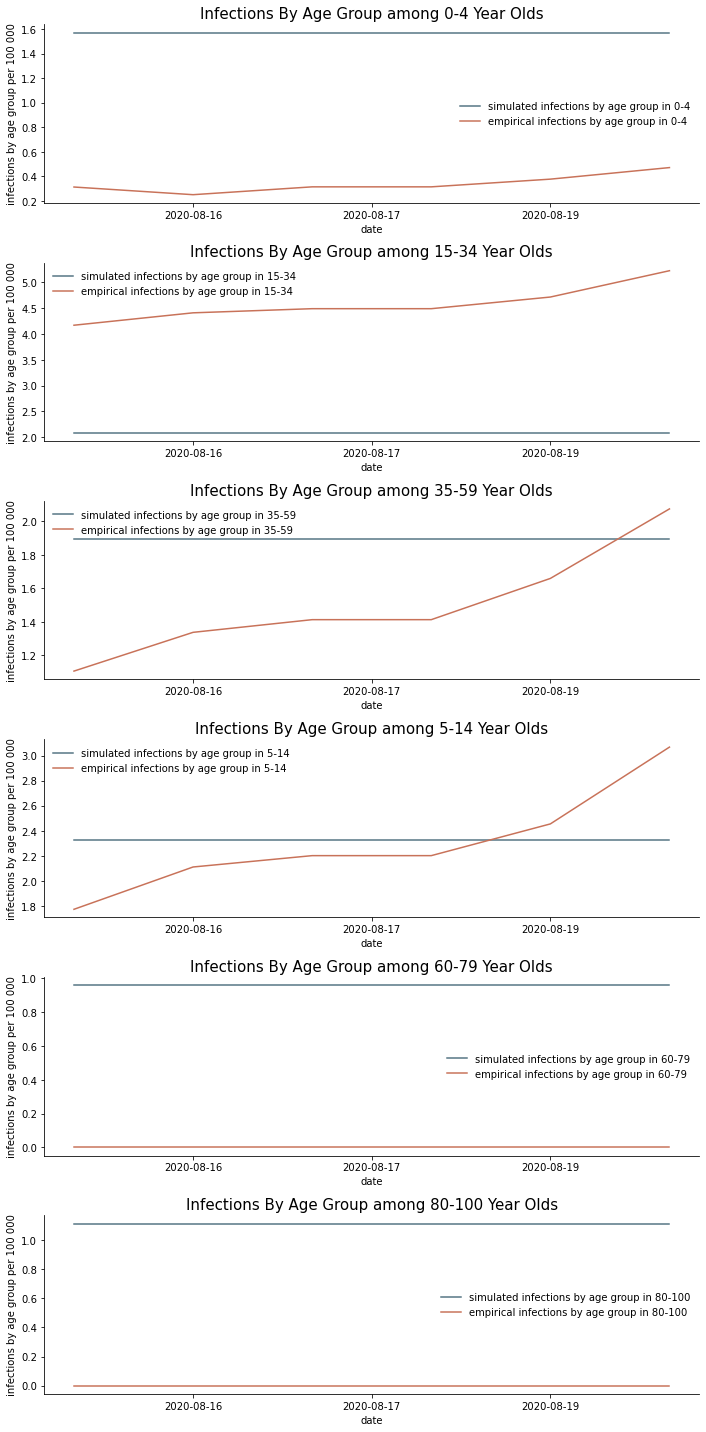

In [9]:
plot_msm_performance(msm_res)